In [18]:
# 0) Imports & style
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB

# Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score
)

sns.set_theme()
plt.rcParams["figure.dpi"] = 120


In [19]:
# 1) Load dataset (robust)
#    - Set CSV_PATH to the correct file if needed.
def load_csv(csv_guess="apartments_for_rent_classified_10K.csv"):
    p = Path(csv_guess)
    if p.exists():
        return pd.read_csv(p, sep=None, engine="python", encoding="cp1252")
    # auto-find if not in CWD
    hits = list(Path(".").rglob("apartments_for_rent_classified*.csv"))
    if not hits:
        raise FileNotFoundError(
            f"Could not find {csv_guess}. Put it next to the notebook or update CSV_PATH."
        )
    print(f"Found CSV at: {hits[0]}")
    return pd.read_csv(hits[0], sep=None, engine="python", encoding="cp1252")

CSV_PATH = "apartments_for_rent_classified_10K.csv"
df = load_csv(CSV_PATH)

# Tidy column names
df.columns = (
    df.columns
      .astype(str)
      .str.strip()
      .str.lower()
      .str.replace(r"\s+", "_", regex=True)
)

print(df.shape)
df.head()


(10000, 22)


,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,790,$790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,NaN,425,$425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,1390,"$1,390",Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,925,$925,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,880,$880,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401


In [20]:
# ============================================
# 2) Define features & target, basic cleaning
# ============================================
TARGET = "price"
assert TARGET in df.columns, f"'{TARGET}' not found in columns!"

# Drop rows without target
df = df.dropna(subset=[TARGET]).copy()
df[TARGET] = df[TARGET].astype(float)

# Features/Target split
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Identify numeric & categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}")


Numeric: 7 | Categorical: 14


In [22]:
# 3) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
len(X_train), len(X_test)


(8000, 2000)

In [24]:
# 4) Preprocessors
#    - Regressor preprocessor: sparse OK
#    - NB preprocessor: dense (GaussianNB needs dense arrays)
num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])
try:
    # newer sklearn
    cat_tf_sparse = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ])
    cat_tf_dense = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
except TypeError:
    # older sklearn
    cat_tf_sparse = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse=True))
    ])
    cat_tf_dense = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

preprocessor_reg = ColumnTransformer([
    ("num", num_tf, num_cols),
    ("cat", cat_tf_sparse, cat_cols)
])

preprocessor_nb = ColumnTransformer([
    ("num", num_tf,   num_cols),
    ("cat", cat_tf_dense, cat_cols)   # DENSE for GaussianNB
])


In [25]:
# 5) Helper to evaluate REGRESSORS (RF, DT, LR)
#    Beginner-friendly metric names:
#      - Average Mistake Size = MAE
#      - Typical Big Mistake  = RMSE
#      - How Much it Explains (%) = R2 * 100
def eval_regressor(name, estimator):
    pipe = Pipeline([
        ("prep",  preprocessor_reg),
        ("model", estimator)
    ])
    pipe.fit(X_train, y_train)
    yhat = pipe.predict(X_test)
    mae  = mean_absolute_error(y_test, yhat)
    rmse = np.sqrt(mean_squared_error(y_test, yhat))
    r2p  = r2_score(y_test, yhat) * 100.0
    return name, pipe, {
        "Average Mistake Size": mae,
        "Typical Big Mistake": rmse,
        "How Much it Explains (%)": r2p
    }


In [26]:
# 6) Train baseline regressors (NO tuning)
results = {}
fitted  = {}

for name, model in [
    ("Random Forest",     RandomForestRegressor(random_state=42, n_jobs=-1)),
    ("Decision Tree",     DecisionTreeRegressor(random_state=42)),
    ("Linear Regression", LinearRegression()),
]:
    nm, pipe, metrics = eval_regressor(name, model)
    fitted[nm]  = pipe
    results[nm] = metrics
    print(f"{nm:17s} | Avg Mistake: {metrics['Average Mistake Size']:.2f} | "
          f"Typical Big Mistake: {metrics['Typical Big Mistake']:.2f} | "
          f"Explains: {metrics['How Much it Explains (%)']:.1f}%")


Random Forest     | Avg Mistake: 238.64 | Typical Big Mistake: 476.90 | Explains: 74.4%
Decision Tree     | Avg Mistake: 295.25 | Typical Big Mistake: 579.38 | Explains: 62.3%
Linear Regression | Avg Mistake: 283.79 | Typical Big Mistake: 806.12 | Explains: 27.0%


In [27]:
# 7) Naive Bayes baseline (classification → price midpoint)
#    - Bin price into quartiles using ALL y for stable bins
#    - Train GaussianNB with dense features
#    - Convert predicted class → bin midpoint for MAE/RMSE/R2

y_all = pd.concat([y_train, y_test]).astype(float)
edges = np.quantile(y_all, [0, .25, .5, .75, 1.0])
edges[0] -= 1e-6  # include_lowest safety
midpoints = (edges[:-1] + edges[1:]) / 2.0

ytr_cls = pd.cut(y_train, bins=edges, labels=False, include_lowest=True)
yte_cls = pd.cut(y_test,  bins=edges, labels=False, include_lowest=True)

nb_pipe = Pipeline([
    ("prep",  preprocessor_nb),
    ("model", GaussianNB())
])
nb_pipe.fit(X_train, ytr_cls)
y_pred_cls = nb_pipe.predict(X_test)

# Map class → midpoint for numeric comparison
pred_price = pd.Series(y_pred_cls, index=y_test.index).map(lambda c: midpoints[int(c)])
mae_nb  = mean_absolute_error(y_test, pred_price)
rmse_nb = np.sqrt(mean_squared_error(y_test, pred_price))
r2p_nb  = r2_score(y_test, pred_price) * 100.0

results["Naive Bayes (binned)"] = {
    "Average Mistake Size": mae_nb,
    "Typical Big Mistake": rmse_nb,
    "How Much it Explains (%)": r2p_nb
}
fitted["Naive Bayes (binned)"] = nb_pipe

print(f"Naive Bayes (binned) | Avg Mistake: {mae_nb:.2f} | Typical Big Mistake: {rmse_nb:.2f} | "
      f"Explains: {r2p_nb:.1f}%")


Naive Bayes (binned) | Avg Mistake: 4952.26 | Typical Big Mistake: 10841.97 | Explains: -13113.5%


In [31]:
# 8) Compare models & pick winner (by RMSE)
results_df = pd.DataFrame(results).T
results_sorted = results_df.sort_values("Typical Big Mistake")  # RMSE primary
display(results_sorted)

best_name = results_sorted.index[0]
print("\n Comparison:")
print(f"• Best by 'Typical Big Mistake' (lower is better): {best_name}")
print(f"• Average Mistake Size: {results_df.loc[best_name, 'Average Mistake Size']:.2f}")
print(f"• Typical Big Mistake: {results_df.loc[best_name, 'Typical Big Mistake']:.2f}")
print(f"• How Much it Explains: {results_df.loc[best_name, 'How Much it Explains (%)']:.1f}%")


,Average Mistake Size,Typical Big Mistake,How Much it Explains (%)
Random Forest,238.636130,476.900518,74.434254
Decision Tree,295.247000,579.384025,62.265733
Linear Regression,283.794462,806.121005,26.952835
Naive Bayes (binned),4952.261500,10841.968019,-13113.538405



 Comparison:
• Best by 'Typical Big Mistake' (lower is better): Random Forest
• Average Mistake Size: 238.64
• Typical Big Mistake: 476.90
• How Much it Explains: 74.4%


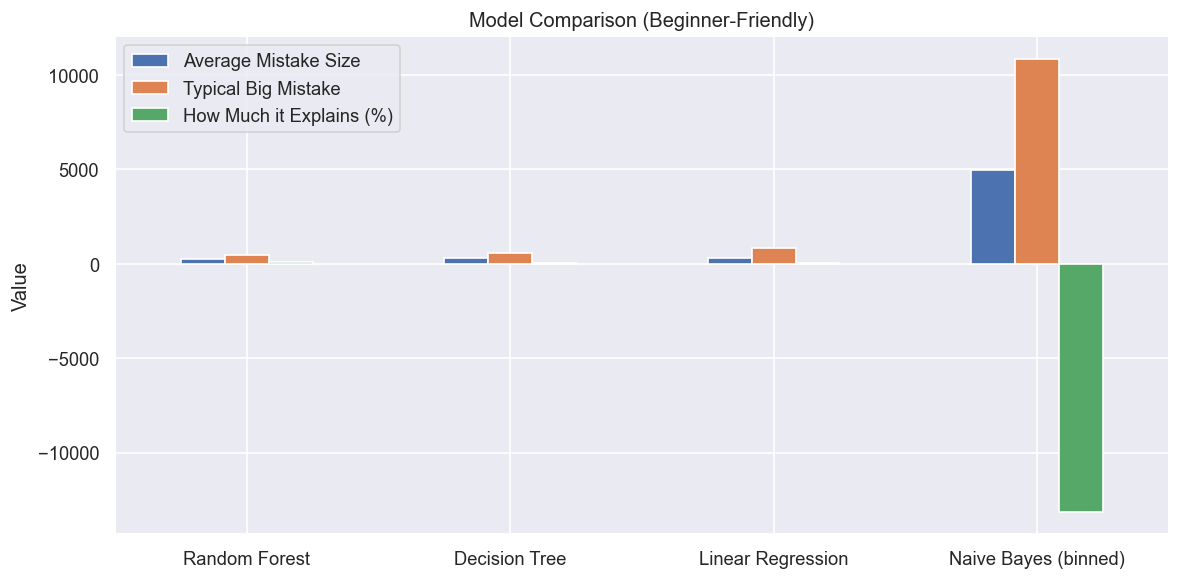

In [ ]:
# 9) Plot metrics

ax = results_df[["Average Mistake Size","Typical Big Mistake","How Much it Explains (%)"]] \
        .plot(kind="bar", figsize=(10,5))
plt.title("Model Comparison (Beginner-Friendly)")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Tuning Random Forest
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best RF params:
{'model__n_estimators': 150, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': None, 'model__bootstrap': False}
Best CV RMSE: 723.3210564483742

 Random Forest — After Tuning (test set)
• Average Mistake Size: 237.10   (baseline 238.64)
• Typical Big Mistake:  495.57  (baseline 476.90)
• How Much it Explains: 72.4% (baseline 74.4%)


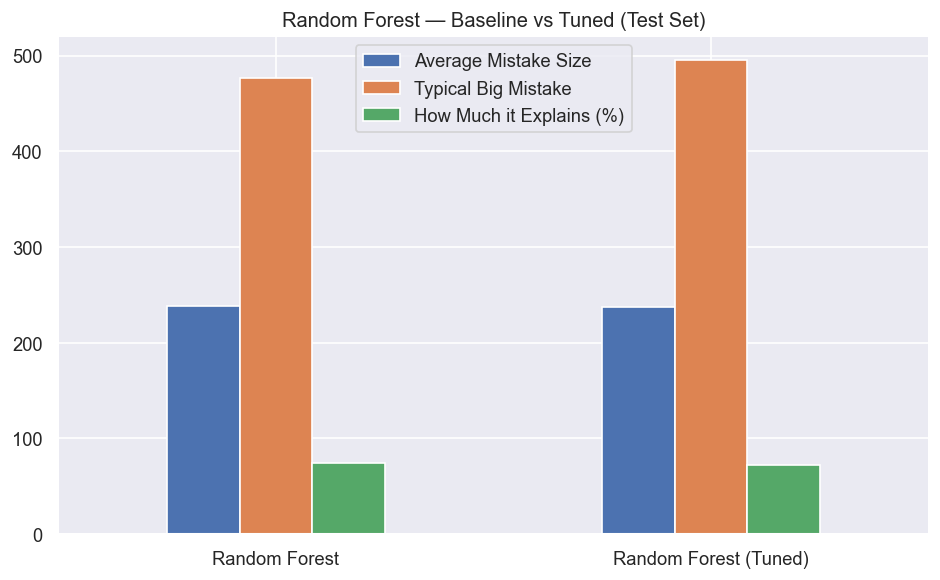

In [33]:
# 10) Tune the winner (Random Forest) only
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import numpy as np

print("Tuning Random Forest")

# Baseline metrics to compare against
baseline_mae  = results_df.loc["Random Forest", "Average Mistake Size"]
baseline_rmse = results_df.loc["Random Forest", "Typical Big Mistake"]
baseline_r2p  = results_df.loc["Random Forest", "How Much it Explains (%)"]

# Base pipeline (same preprocessor as before)
rf_base = Pipeline([
    ("prep",  preprocessor_reg),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1)),
])

# Hyperparameter search space (reasonable, not too heavy)
param_dist = {
    "model__n_estimators":     [150, 250, 350, 500],
    "model__max_depth":        [None, 10, 15, 20, 30],
    "model__min_samples_split":[2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features":     ["sqrt", "log2", 0.5],
    "model__bootstrap":        [True, False],
}

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=25,                 # try more for a deeper search if you have time
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    scoring="neg_root_mean_squared_error"  # smaller RMSE is better
)

rf_search.fit(X_train, y_train)

print("\nBest RF params:")
print(rf_search.best_params_)
print("Best CV RMSE:", -rf_search.best_score_)

# Evaluate tuned RF on the held-out test set (beginner-friendly metrics)
best_rf = rf_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)

tuned_mae  = mean_absolute_error(y_test, y_pred_tuned)                          # Average Mistake Size
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))                  # Typical Big Mistake
tuned_r2p  = r2_score(y_test, y_pred_tuned) * 100.0                             # How Much it Explains (%)

print("\n Random Forest — After Tuning (test set)")
print(f"• Average Mistake Size: {tuned_mae:.2f}   (baseline {baseline_mae:.2f})")
print(f"• Typical Big Mistake:  {tuned_rmse:.2f}  (baseline {baseline_rmse:.2f})")
print(f"• How Much it Explains: {tuned_r2p:.1f}% (baseline {baseline_r2p:.1f}%)")

# Optionally update the results table so plots/summary reflect the tuned model
results_df.loc["Random Forest (Tuned)"] = {
    "Average Mistake Size": tuned_mae,
    "Typical Big Mistake": tuned_rmse,
    "How Much it Explains (%)": tuned_r2p
}

# Quick visual comparison: baseline vs tuned
results_df.loc[["Random Forest", "Random Forest (Tuned)"],
               ["Average Mistake Size","Typical Big Mistake","How Much it Explains (%)"]].plot(
    kind="bar", figsize=(8,5))
plt.title("Random Forest — Baseline vs Tuned (Test Set)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
